# KKBox Customer Segmentation Analysis
### w/ SkLearn

---

# Part 1.B: <font color=green>*Mean-Shift Model Creation and Evaluation*</font>

---

In [1]:
# General Imports
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import matplotlib.cm as cm
import time

# Evaluation Imports
from sklearn.cluster import KMeans, MeanShift, estimate_bandwidth, MiniBatchKMeans
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

## Create Spark Session and Import Data

In [2]:
# Import DRV_Jan2016 as Pandas 
DRV_Jan20160 = pd.read_csv('D:\J-5 Local\Datasets_KKBox User Data_Monthly Datasets_DRV_Jan2016000000000000')
DRV_Jan20161 = pd.read_csv('D:\J-5 Local\Datasets_KKBox User Data_Monthly Datasets_DRV_Jan2016000000000001')
DRV_Jan20162 = pd.read_csv('D:\J-5 Local\Datasets_KKBox User Data_Monthly Datasets_DRV_Jan2016000000000002')

DRV_Jan2016x = pd.concat([DRV_Jan20160,DRV_Jan20161,DRV_Jan20162])

del DRV_Jan20160
del DRV_Jan20161
del DRV_Jan20162

## Model Pre-Processing

#### <font color=purple>*Split Feautres by Categorical or Continuous*</font>

In [3]:
# Create list of Categorical feature names
cat_feats = ['is_auto_renew', 'total_spent_zero', 'city_agg', 'payment_method_agg', 'never_active_subscriber']

# Create list of Continuous feature names
cont_feats = [x for x in DRV_Jan2016x.columns if x not in cat_feats]
cont_feats.remove('msno')
cont_feats.remove('is_churn')
cont_feats.remove('membership_expire_date')
cont_feats.remove('registration_init_time')
cont_feats.remove('city')
cont_feats.remove('bd')
cont_feats.remove('payment_method_id')
cont_feats.remove('is_net_paid_amount')
cont_feats.remove('registered_via')

#### <font color=purple>*Created Stratified Sample*</font>

In [4]:
X_train, X_test, y_train, y_test = train_test_split(DRV_Jan2016x[cont_feats], DRV_Jan2016x['is_churn'], test_size=0.33, random_state=42, stratify=DRV_Jan2016x['is_churn'])

#### <font color=purple>*Feature Scaling*</font>

In [7]:
# Scale all features as we are dealing with a distance algorithm
X_test = StandardScaler().fit_transform(X_test)

## Transform and Evaluate Model: Mean-Shift

#### <font color=blue>Mean Shift - Model 1 Baseline</font>

We will start by determining the bandwidth for our initial Mean-shift model and running it. After we will play around with Bandwidth values to see if we can get better performance.

In [8]:
from sklearn.cluster import MeanShift, estimate_bandwidth

# Here we set the bandwidth. This function automatically derives a bandwidth
# number based on an inspection of the distances among points in the data.
X = X_test
bandwidth = estimate_bandwidth(X, quantile=0.2, n_samples=500)
print(f'Bandwidth: {bandwidth}')

Bandwidth: 11.769535159443334


In [33]:
# Instatiate Mean-Shift Object.
start = time.time()
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)

# Extract cluster assignments for each data point.
labels = ms.fit_predict(X)

# Coordinates of the cluster centers.
cluster_centers = ms.cluster_centers_

# Count our clusters.
n_clusters_ = len(np.unique(labels))

# Print Silhuoette Score and calinski_harabasz_score
silhouette_avg = silhouette_score(X, labels)
ch_score = metrics.calinski_harabasz_score(X, labels)  
print("For n_clusters =", n_clusters_)
print("The average silhouette_score is :", silhouette_avg)
print("The calinski_harabasz_score is :", ch_score)
print("Mean Shift bandwidth: {}".format(bandwidth))
print('')

# Calculate Time Spent
end = time.time()
print('Time spent for training: {}'.format(round(end-start)))

For n_clusters = 12
The average silhouette_score is : 0.42978670306653743
The calinski_harabasz_score is : 1582.0107355812181
Mean Shift bandwidth: 11.769535159443334

Time spent for training: 1330


Given the use-case, and my limited information on the domain, I find 12 clusters to be a bit much. However, let's look that the cluster distributions to get a better sense of their relative compositions.

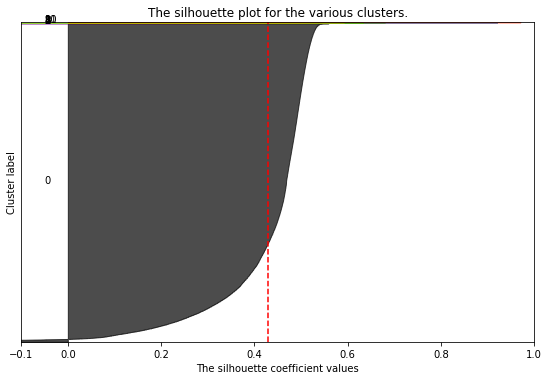

Time spent for training: 871


In [35]:
plt.figure(figsize=(15,15))
for i, band in enumerate([11.76]):
    
    # Compute the silhouette scores for each sample
    start = time.time()
    sample_silhouette_values = silhouette_samples(X, labels)

    ## Cluster Visualization ##

    # Create a subplot with 1 row and 2 columns
    i = 0
    plt.subplot(3,2,i+1)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    plt.xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blan space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    plt.ylim([0, len(X) + (n_clusters_ + 1) * 10])

    y_lower = 10
    for i in range(n_clusters_):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters_)
        plt.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    plt.title("The silhouette plot for the various clusters.")
    plt.xlabel("The silhouette coefficient values")
    plt.ylabel("Cluster label")


    # The vertical line for average silhouette score of all the values
    plt.axvline(x=silhouette_avg, color="red", linestyle="--")

    plt.yticks([])  # Clear the yaxis labels / ticks
    plt.xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

plt.tight_layout()
plt.show()

# Calculate Time Spent
end = time.time()
print('Time spent for training: {}'.format(round(end-start)))

This will not work for us. 1 Massive cluster with 14 other clusters that are incomparable in size. Lets adjust the bandwidth and see if we can get better results.

#### <font color=blue>Mean Shift - Model 2 w/ Bandwidth Adjustments</font>

As we started off with a ***Bandwidth = 11.76***, let's pass an array of bandwidths to compare.

In [ ]:
plt.figure(figsize=(15,15))
for i, band in enumerate([7.76, 9.76, 11.76, 13.76]):

    ## Cluster Calculation ##

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = MeanShift(bandwidth=band, bin_seeding=True)
    cluster_labels = clusterer.fit_predict(X)
    
    # Count our clusters.
    n_clusters_ = len(np.unique(cluster_labels))

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    # The silhouette_score gives the average value for all the samples.
    silhouette_avg = silhouette_score(X, cluster_labels)
    ch_score = metrics.calinski_harabasz_score(X, cluster_labels)  
    print("For n_clusters =", n_clusters_)
    print("The average silhouette_score is :", silhouette_avg)
    print("The calinski_harabasz_score is :", ch_score)
    print("Mean Shift bandwidth: {}".format(band))
    print('')

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)
    
    ## Cluster Visualization ##
    
    # Create a subplot with 1 row and 2 columns
    plt.subplot(3,2,i+1)
    
    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    plt.xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    plt.ylim([0, len(X_scaled) + (n_clusters_ + 1) * 10])

    y_lower = 10
    for i in range(n_clusters_):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters_)
        plt.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    plt.title("The silhouette plot for the various clusters.")
    plt.xlabel("The silhouette coefficient values")
    plt.ylabel("Cluster label")
    

    # The vertical line for average silhouette score of all the values
    plt.axvline(x=silhouette_avg, color="red", linestyle="--")

    plt.yticks([])  # Clear the yaxis labels / ticks
    plt.xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

plt.tight_layout()
plt.show()